## EXPERIMENT SETUP: _FREEZE, REINIT, POOLING, DENSE:REINIT BOTH_
- percentages_set_1 = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]
- dataset: same as before MNIST 5 to 5

- architecture:
  - Conv 1 (5,5), channels=10
  - Relu
  - Conv 2 (5,5), channels=10
  - Relu
  - Conv 3 (5,5), channels=10
  - Relu
  - _POOLING_
  - Dense 1 (x, a) x=output shape of prev layer, a:random hidden layer width (we use 128)
  - Relu
  - Dense 2 (a, 5)
  - softmax

- lr pretraining = 0.001
- lr finetuning = 0.0001
- lr end-to-end = 0.001

- Freezing the layers before the cut: _YES_
- Reinitializing the Convolutional layers after the cut: _YES_
- Reinitializing Dense 1: _YES_
- Reinitializing Dense 2: _YES_


# Setup and utils

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import json
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from types import SimpleNamespace
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
from scipy.interpolate import griddata

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


device(type='cuda')

In [2]:
# ------------------------------------ MODEL UTILS ----------------------------------------------
class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling=True):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=1))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            input_dim = (input_dim - kernel_size + 2 * 1) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and (i+1) % depth == 0:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        flattened_size = in_channels * input_dim * input_dim

        # Add two fully connected layers for classification
        self.fc_1 = nn.Linear(flattened_size, hidden_dim_lin)
        self.relu = activation_function()
        self.fc_2 = nn.Linear(hidden_dim_lin, output_dim)

        # Add log softmax layer for multi-class classification output
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
      # Iterate over each module in the CustomCNN class
      for layer_name, layer in self.named_children():
          # Process the input tensor through convolutional and activation layers
          if "conv" in layer_name or "act" in layer_name:
              x = layer(x)
          # Process the input tensor through pooling layers if they exist
          elif "pool" in layer_name:
              x = layer(x)
          # If reached fully connected layers, break the loop
          elif isinstance(layer, nn.Linear):
              break

      # Flatten the tensor to fit the input shape of the fully connected layers
      x = x.view(x.size(0), -1)

      # Pass the tensor through the fully connected layers
      x = self.fc_1(x)
      x = self.relu(x)
      x = self.fc_2(x)

      # Return log softmax activated output
      return self.logsoftmax(x)

def generate_cnn(input_dim, output_dim, depth, num_channels, hidden_dim_lin, kernel_size, activation_function=nn.ReLU, use_pooling=True):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling)
    return model

class Trainer:
    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """
    def __init__(self, model, dataloader, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params
        self.device = torch.device(params['device'])
        self.optimizer = optim.SGD(model.parameters(), lr=params['lr'])
        # optim.SGD(network.parameters(), lr=learning_rate, momentum=momentum)
        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0
        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)

    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):
          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])
          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self, verbose=1):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            if verbose >= 1:
                self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
                self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):
    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

def cut_custom_cnn_model(model, cut_point, freeze=True, reinitialize=False):
    """
    Cut the CustomCNN model at a specific layer and reinitialize the weights for layers after cut_point.

    Parameters:
    - model (CustomCNN): Original CustomCNN model.
    - cut_point (int): Layer index (in terms of conv layers) at which to modify the model.
    - freeze (bool): If True, layers before cut_point will have their weights frozen.
    - reinitialize (bool): If True, layers after cut_point will have their weights reinitialized.

    Returns:
    - new_model (CustomCNN): Modified model.
    """

    new_model = copy.deepcopy(model)

    # Get names of layers in the model
    layer_names = list(new_model._modules.keys())

    # Find indices of Conv layers
    conv_indices = [i for i, name in enumerate(layer_names) if 'conv' in name]
    #print(conv_indices)

    # If freeze is True, set requires_grad to False for layers before cut_point
    if freeze:
        for idx in conv_indices[:cut_point]:
            for param in getattr(new_model, layer_names[idx]).parameters():
                param.requires_grad = False

    # Reinitialize layers after cut_point
    if reinitialize:
        for idx in conv_indices[cut_point:]:
            layer = getattr(new_model, layer_names[idx])
            nn.init.kaiming_uniform_(layer.weight, a=0, mode='fan_in', nonlinearity='relu')
            if layer.bias is not None:
                nn.init.constant_(layer.bias, 0)

    # reinit the final dense layer anyway
    new_model.fc_2.reset_parameters()

    # if reinit_both_dense: reinit the one before the last one too
    if params["reinit_both_dense"]:
        new_model.fc_1.reset_parameters()

    return new_model

In [3]:
# --------------------------------- DATA UTILS -----------------------------------
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)

class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1, num_workers=0):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)
        SEED = 42
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(SEED))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(SEED))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Use the RelabeledSubset for fine-tuning test datasets
        finetune_test_data = RelabeledSubset(finetune_test_data, 5)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

class TransferLearningMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningMNISTObj, phase):
        """
        Initializes the TransferLearningMNISTWrapper object.

        Parameters:
        - transferLearningMNISTObj: An instance of the TransferLearningMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

In [ ]:
# ------------------------------------------ PLOTTING UTILS -------------------------------------------
'''def effective_rank(singular_values):
    sigma_max = np.max(singular_values)
    sigma_min = singular_values[-1] if singular_values[-1] > 0 else np.min(singular_values[singular_values > 0])
    # print(sigma_max, sigma_min)
    print(np.sqrt(sigma_max / sigma_min))
    print('----')
    return np.sqrt(sigma_max / sigma_min)'''

def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

In [4]:
percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]

# cuts=0 means: end-to-end model if we are reinitializing
cuts = [0,1,2,3]
seed_set = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # currently not being used
repeats = 3
batch_size = 4096

In [8]:
dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'finetune')

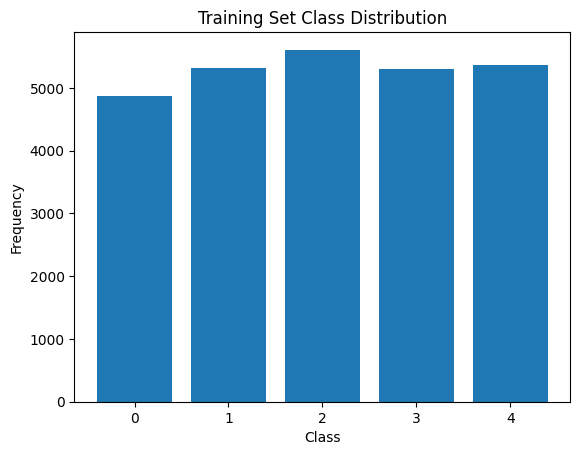

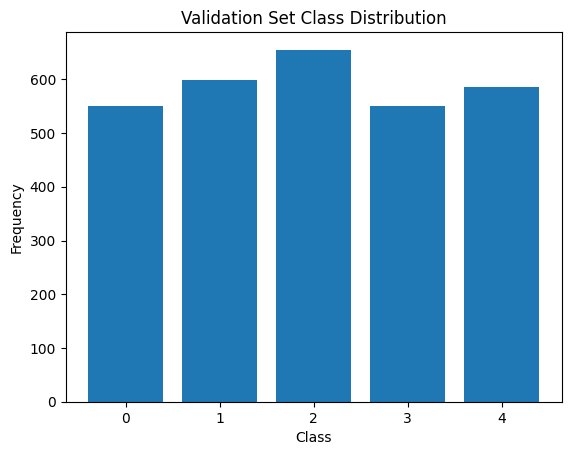

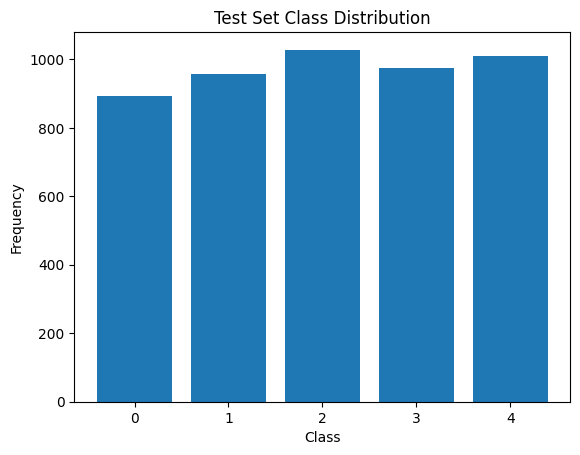

In [10]:
def analyze_dataloader(dataloader):
    class_counts = {}

    # Iterate over batches
    for _, labels in dataloader:
        for label in labels:
            label = label.item()  # Convert tensor to integer
            class_counts[label] = class_counts.get(label, 0) + 1

    return class_counts

# Analyze train, validation, and test loaders
train_class_distribution = analyze_dataloader(dataloader_wrapped.train_loader)
val_class_distribution = analyze_dataloader(dataloader_wrapped.val_loader)
test_class_distribution = analyze_dataloader(dataloader_wrapped.test_loader)

# Function to plot the class distribution
def plot_distribution(class_distribution, title):
    labels = list(class_distribution.keys())
    counts = list(class_distribution.values())
    
    plt.bar(labels, counts)
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

# Visualize distributions
plot_distribution(train_class_distribution, 'Training Set Class Distribution')
plot_distribution(val_class_distribution, 'Validation Set Class Distribution')
plot_distribution(test_class_distribution, 'Test Set Class Distribution')

In [15]:
sampled_percentage = 0.1

train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))

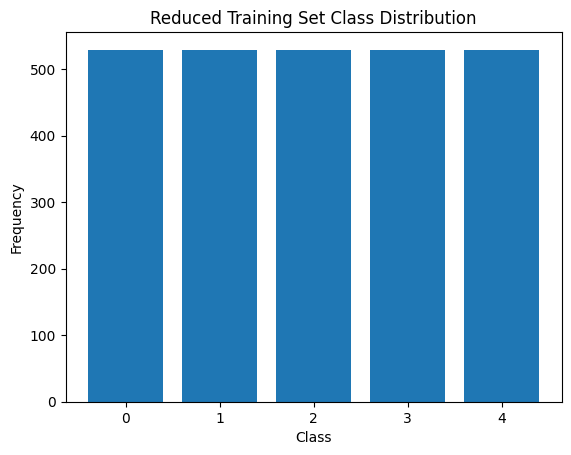

In [16]:
train_class_distribution_reduced = analyze_dataloader(train_loader_reduced)
plot_distribution(train_class_distribution_reduced, 'Reduced Training Set Class Distribution')

In [ ]:
dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

## Pretraining



In [3]:
# Changes Here for the experiments
params = {
      'depth': 3,
      'width': 10, # num channels for CNN
      'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr': 0.001,
      'num_train': 20,
      'early_stop_patience': 6,
      'save_best': True,
      'save_checkpoints': True,
      'is_cnn': True,
      'is_debug': False,
      'classification_report_flag': False,
      'use_pooling': False,   # CHANGE
      'freeze': False,         # CHANGE: freeze the conv layers before the cut
      'reinit': True,         # CHANGE: reinit the conv lyers only after the cut
      'reinit_both_dense': True,   # CHANGE: True for reinitialize both dense layers, False for reinit only the last dense layer
      'needs_gs': False
    }

# Create DNN model
pretrained_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
pretrained_model.to(device)

100%|██████████| 9912422/9912422 [00:00<00:00, 108754947.17it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 46429932.47it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 22064412.11it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8254128.58it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CustomCNN(
  (conv0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv2): Conv2d(10, 10, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (fc_1): Linear(in_features=4840, out_features=128, bias=True)
  (relu): ReLU()
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [4]:
# Train and evaluate
trainer = Trainer(pretrained_model, dataloader_wrapped, params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Epoch: 0 	Training Accuracy: 58.21%
Validation Accuracy: 56.26%
Epoch: 1 	Training Accuracy: 87.65%
Validation Accuracy: 88.00%
Epoch: 2 	Training Accuracy: 89.36%
Validation Accuracy: 88.62%
Epoch: 3 	Training Accuracy: 92.69%
Validation Accuracy: 92.55%
Epoch: 4 	Training Accuracy: 94.47%
Validation Accuracy: 93.98%
Epoch: 5 	Training Accuracy: 94.87%
Validation Accuracy: 94.31%
Epoch: 6 	Training Accuracy: 95.56%
Validation Accuracy: 95.16%
Epoch: 7 	Training Accuracy: 95.89%
Validation Accuracy: 95.29%
Epoch: 8 	Training Accuracy: 96.11%
Validation Accuracy: 95.42%
Epoch: 9 	Training Accuracy: 96.19%
Validation Accuracy: 95.62%
Epoch: 10 	Training Accuracy: 96.49%
Validation Accuracy: 95.55%
Epoch: 11 	Training Accuracy: 96.64%
Validation Accuracy: 95.78%
Epoch: 12 	Training Accuracy: 96.82%
Validation Accuracy: 96.14%
Epoch: 13 	Training Accuracy: 97.04%
Validation Accuracy: 96.40%
Epoch: 14 	Training Accuracy: 97.15%
Validation Accuracy: 96.70%
Epoch: 15 	Training Accuracy: 97.29

conv0.weight: 40.1149
conv1.weight: 387.0108
conv2.weight: 382.3450
fc_1.weight: 112.9017
fc_2.weight: 9.8708


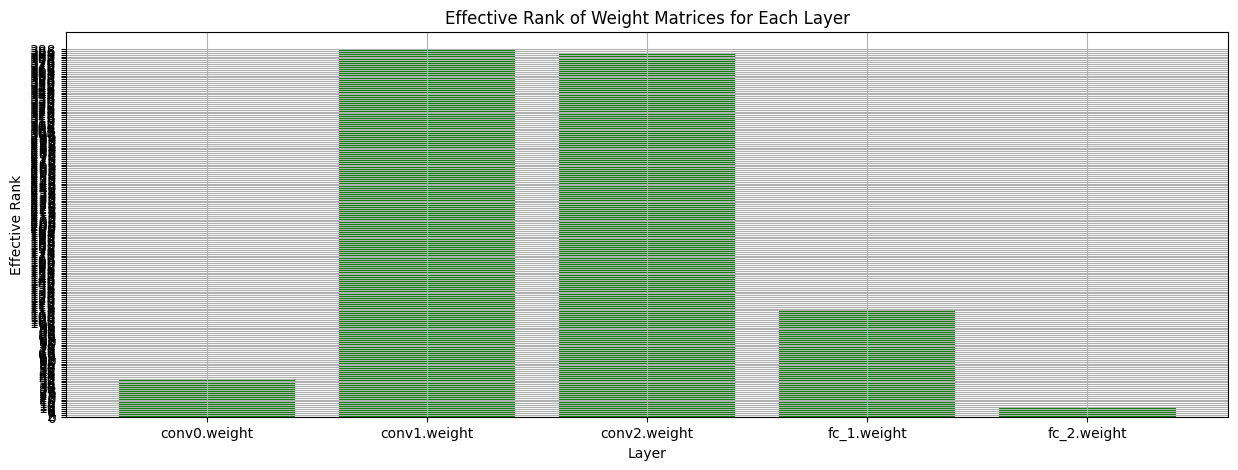

In [5]:
# Effective Rank of Pretrained model
plot_layer_effective_ranks(pretrained_model)  # Note: You'll need to define or load 'model' before calling this function


## Fine-tuning Experiments

In [ ]:
params["lr"] = 0.0001
dataloader_wrapped.update_phase('finetune')
key = (sampled_percentage, sampled_cut_point, repeat)

In [ ]:
def tune_learning_rate(model, dataset, learning_rates, params):
    best_lr = learning_rates[0]
    best_acc = 0

    for lr in learning_rates:
        print(f"Trying learning rate: {lr}")
        # Create a copy of the model for each trial
        model_copy = copy.deepcopy(model)
        # Update the learning rate in params
        trial_params = copy.deepcopy(params)
        trial_params["lr"] = lr

        # Initialize trainer with the model copy and trial parameters
        trial_trainer = Trainer(model_copy, dataset, trial_params)
        _, val_acc, _, _ = trial_trainer.train(verbose=0)  # Assuming train() returns validation accuracy as well

        if val_acc > best_acc:
            best_acc = val_acc
            best_lr = lr

    return best_lr

In [ ]:
for sampled_percentage in tqdm(percentages, desc="Overall Progress"):
    # Set repeats based on sampled_percentage
    if sampled_percentage < 0.01:
        repeats = 10
        params["needs_gs"] = True  # Change a parameter for percentages below 0.01
    elif 0.01 <= sampled_percentage < 0.5:
        repeats = 5
        params["needs_gs"] = False
    else:
        repeats = 3
        params["needs_gs"] = False

    for repeat in tqdm(range(repeats), desc=f"Percentage {sampled_percentage}"):
        # Reduce the dataset
        train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
        val_loader_reduced = reduce_dataset(dataloader_wrapped.val_loader, sampled_percentage, seed=random.randint(0, 100))
        test_loader_reduced = reduce_dataset(dataloader_wrapped.test_loader, sampled_percentage, seed=random.randint(0, 100))

        dataset_namespace_new = SimpleNamespace(
            train_loader=train_loader_reduced, 
            val_loader=val_loader_reduced, 
            test_loader=test_loader_reduced
        )

        # Finetune Model Training
        for sampled_cut_point in cuts:
            model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, freeze=params["freeze"], reinitialize=params["reinit"])
            
            if params["some_parameter"]:
                learning_rates = [0.0001, 0.0005, 0.001]
                best_lr = tune_learning_rate(model_new, dataset_namespace_new, learning_rates, params)
                params["lr"] = best_lr  # Update learning rate in params

            
            trainer = Trainer(model_new, dataset_namespace_new, params)
            train_acc, test_acc, _, _ = trainer.train(verbose=0)
            results_dict_finetune[(sampled_percentage, sampled_cut_point, repeat)] = {"train_acc": train_acc, "test_acc": test_acc}
        
        # Baseline Model Training
        model_baseline = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                                  hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
        model_baseline.to(device)
        
                # Hyperparameter tuning if some_parameter is True
        if params["some_parameter"]:
            learning_rates = [0.0001, 0.0005, 0.001]
            best_lr = tune_learning_rate(model_baseline, dataset_namespace_new, learning_rates, params)
            params["lr"] = best_lr  # Update learning rate in params
        
        trainer = Trainer(model_baseline, dataset_namespace_new, params)
        train_acc, test_acc, _, _ = trainer.train(verbose=0)
        results_dict_baseline[(sampled_percentage, -1, repeat)] = {"train_acc": train_acc, "test_acc": test_acc}

In [6]:
# params["lr"] = 0.0001
# dataloader_wrapped.update_phase('finetune')
# # percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]

# # Store results
# results = []
# # Store unique combinations that have been tested
# tested_combinations = set()

# for sampled_percentage in percentages:

#     if sampled_percentage < 0.01:
#         repeats = 10
#     elif 0.01 <= sampled_percentage < 0.5:
#         repeats = 5
#     else:
#         repeats = 3
        
#     for sampled_cut_point in cuts:
#         for repeat in range(repeats):
            
#             # Unique key for each combination
#             key = (sampled_percentage, sampled_cut_point, repeat)
            
#             # Add the combination to the tested set
#             tested_combinations.add((sampled_percentage, sampled_cut_point))

#             # # Print or log the sampled values for transparency
#             # print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Repeat: {repeat}")

#             # Reduce the dataset
#             train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
#             val_loader_reduced = reduce_dataset(dataloader_wrapped.val_loader, sampled_percentage, seed=random.randint(0, 100))
#             test_loader_reduced = reduce_dataset(dataloader_wrapped.test_loader, sampled_percentage, seed=random.randint(0, 100))

#             dataset_namespace_new = SimpleNamespace(
#                 train_loader=train_loader_reduced, 
#                 val_loader=val_loader_reduced, 
#                 test_loader=test_loader_reduced
#             )
            
#             # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
#             model_new = cut_custom_cnn_model(pretrained_model, cut_point=sampled_cut_point, freeze=params["freeze"], reinitialize=params["reinit"])

#             # Train and evaluate
#             trainer = Trainer(model_new, dataset_namespace_new, params)
#             train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
            
#             results_dict_finetune[key] = {
#                 "train_acc": train_acc,
#                 "test_acc": test_acc
#             }
            
#             # Print or logging can be here
#             print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Repeat: {repeat}")
#             print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

#             # Store the results
#             results.append((sampled_percentage, sampled_cut_point, repeat, train_acc, test_acc))


Sampled Percentage: 0.001, Sampled Cut Point: 0, Repeat: 0
Training Accuracy: 0.9200, Test Accuracy: 0.6589

Sampled Percentage: 0.001, Sampled Cut Point: 0, Repeat: 1
Training Accuracy: 1.0000, Test Accuracy: 0.4900

Sampled Percentage: 0.001, Sampled Cut Point: 0, Repeat: 2
Training Accuracy: 1.0000, Test Accuracy: 0.7449

Sampled Percentage: 0.001, Sampled Cut Point: 1, Repeat: 0
Training Accuracy: 0.9200, Test Accuracy: 0.7040

Sampled Percentage: 0.001, Sampled Cut Point: 1, Repeat: 1
Training Accuracy: 0.9600, Test Accuracy: 0.6472

Sampled Percentage: 0.001, Sampled Cut Point: 1, Repeat: 2
Training Accuracy: 0.9600, Test Accuracy: 0.6912

Sampled Percentage: 0.001, Sampled Cut Point: 2, Repeat: 0
Training Accuracy: 0.9600, Test Accuracy: 0.7747

Sampled Percentage: 0.001, Sampled Cut Point: 2, Repeat: 1
Training Accuracy: 0.9600, Test Accuracy: 0.7712

Sampled Percentage: 0.001, Sampled Cut Point: 2, Repeat: 2
Training Accuracy: 1.0000, Test Accuracy: 0.6929

Sampled Percentage

### Print the results and save somewhere for future analysis

In [8]:
# #training of baseline, end to end, models (#trials x #percentages)

# params["lr"] = 0.001 #back to training learning rate 
# dataloader_wrapped.update_phase('finetune')
# # percentages = [0.001, 0.002, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5, 0.8, 1]

# for sampled_percentage in percentages:

#     if sampled_percentage < 0.01:
#         repeats = 10
#     elif 0.01 <= sampled_percentage < 0.5:
#         repeats = 5
#     else:
#         repeats = 3
    
#     for repeat in range(repeats):
        
#         # Unique key for each combination
#         key = (sampled_percentage, sampled_cut_point, repeat)

#         # Reduce the dataset
#         train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
#         val_loader_reduced = reduce_dataset(dataloader_wrapped.val_loader, sampled_percentage, seed=random.randint(0, 100))
#         test_loader_reduced = reduce_dataset(dataloader_wrapped.test_loader, sampled_percentage, seed=random.randint(0, 100))

#         dataset_namespace_new = SimpleNamespace(
#             train_loader=train_loader_reduced, 
#             val_loader=val_loader_reduced, 
#             test_loader=test_loader_reduced
#         )

#         # Copy and then cut the model - we already deepcopy it in the function: pretrained_model
#         model_baseline = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
#                  hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
#         model_baseline.to(device)

#         # Train and evaluate
#         trainer = Trainer(model_baseline, dataset_namespace_new, params)
#         train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
        
#         results_dict_baseline[key] = {
#             "train_acc": train_acc,
#             "test_acc": test_acc
#         }
        
#         # Print or logging can be here
#         print(f"\nSampled Percentage: {sampled_percentage}, Sampled Cut Point: {sampled_cut_point}, Repeat: {repeat}")
#         print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

#         # Store the results
#         results.append((sampled_percentage, -1, repeat, train_acc, test_acc)) # -1 for the cut point means it's baseline


Sampled Percentage: 0.001, Sampled Cut Point: -1, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.4000, Test Accuracy: 0.3378

Sampled Percentage: 0.001, Sampled Cut Point: -1, Repeat: 1
Training Accuracy: 1.0000, Test Accuracy: 0.7332

Sampled Percentage: 0.001, Sampled Cut Point: -1, Repeat: 2
Training Accuracy: 1.0000, Test Accuracy: 0.7274

Sampled Percentage: 0.002, Sampled Cut Point: -1, Repeat: 0
Early stopping invoked.
Training Accuracy: 0.8800, Test Accuracy: 0.7241

Sampled Percentage: 0.002, Sampled Cut Point: -1, Repeat: 1
Early stopping invoked.
Training Accuracy: 0.4000, Test Accuracy: 0.3372

Sampled Percentage: 0.002, Sampled Cut Point: -1, Repeat: 2
Training Accuracy: 0.9600, Test Accuracy: 0.8151

Sampled Percentage: 0.005, Sampled Cut Point: -1, Repeat: 0
Training Accuracy: 0.8923, Test Accuracy: 0.8420

Sampled Percentage: 0.005, Sampled Cut Point: -1, Repeat: 1
Training Accuracy: 0.8846, Test Accuracy: 0.8091

Sampled Percentage: 0.005, Sampled Cut Point: -

In [7]:
print(results)

[(0.001, 0, 0, 0.92, 0.6589179181238428), (0.001, 0, 1, 1.0, 0.4900226290886649), (0.001, 0, 2, 1.0, 0.7449084550504012), (0.001, 1, 0, 0.92, 0.7039703764657478), (0.001, 1, 1, 0.96, 0.6471919358156758), (0.001, 1, 2, 0.96, 0.6912157992182678), (0.001, 2, 0, 0.96, 0.7747377082904752), (0.001, 2, 1, 0.96, 0.7712404854968113), (0.001, 2, 2, 1.0, 0.6928615511211684), (0.001, 3, 0, 1.0, 0.7440855790989508), (0.001, 3, 1, 0.96, 0.8064184324213125), (0.001, 3, 2, 1.0, 0.7601316601522321), (0.002, 0, 0, 1.0, 0.7953096070767331), (0.002, 0, 1, 0.94, 0.8140300349722279), (0.002, 0, 2, 0.94, 0.7438798601110882), (0.002, 1, 0, 0.7, 0.6056367002674347), (0.002, 1, 1, 0.46, 0.4614276897757663), (0.002, 1, 2, 0.94, 0.7722690804361243), (0.002, 2, 0, 0.86, 0.7560172803949805), (0.002, 2, 1, 0.96, 0.8366591236371117), (0.002, 2, 2, 0.86, 0.8142357539600905), (0.002, 3, 0, 0.92, 0.8339847767948981), (0.002, 3, 1, 0.96, 0.8695741616951245), (0.002, 3, 2, 0.98, 0.8613454021806213), (0.005, 0, 0, 0.969230

## Visualizations

### The Results Table and 3D plot (both go into the report)

In [9]:
# # first of all convert results to df and calculate the mean and std of repats
# repeats_mean = []
# i = 0
# for sampled_percentage in percentages:
#     for sampled_cut_point in cuts:
#         train, test = [], []
#         for repeat in range(repeats):
#             train.append(results[i][3])
#             test.append(results[i][4])
#             i += 1
#         repeats_mean.append((sampled_percentage, sampled_cut_point, np.mean(train), np.std(train), np.mean(test), np.std(test)))
# df = pd.DataFrame(repeats_mean, columns=['Percentage', 'Cut Point', 'Mean Train Accuracy', 'Std Train Accuracy', 'Mean Test Accuracy', 'Std Test Accuracy'])
# df

,Percentage,Cut Point,Mean Train Accuracy,Std Train Accuracy,Mean Test Accuracy,Std Test Accuracy
0,0.001,0,0.973333,0.037712,0.631283,0.105876
1,0.001,1,0.946667,0.018856,0.680793,0.024323
2,0.001,2,0.973333,0.018856,0.746280,0.037799
3,0.001,3,0.986667,0.018856,0.770212,0.026427
4,0.002,0,0.960000,0.028284,0.784407,0.029658
5,0.002,1,0.700000,0.195959,0.613111,0.127010
6,0.002,2,0.893333,0.047140,0.802304,0.033986
7,0.002,3,0.953333,0.024944,0.854968,0.015213
8,0.005,0,0.702564,0.350279,0.650278,0.304831
9,0.005,1,0.810256,0.186775,0.736200,0.163622


In [10]:
# Create a 3D scatter plot
fig = px.scatter_3d(df,
                    x='Percentage',
                    y='Cut Point',
                    z='Mean Test Accuracy',  # or 'Train Accuracy' if you want to visualize training accuracy
                    color='Mean Test Accuracy',  # color scale based on test accuracy
                    size_max=18,
                    opacity=0.7)

# Set axis labels
fig.update_layout(scene=dict(xaxis_title='Percentage',
                             yaxis_title='Cut Point',
                             zaxis_title='Test Accuracy'))

fig.show()

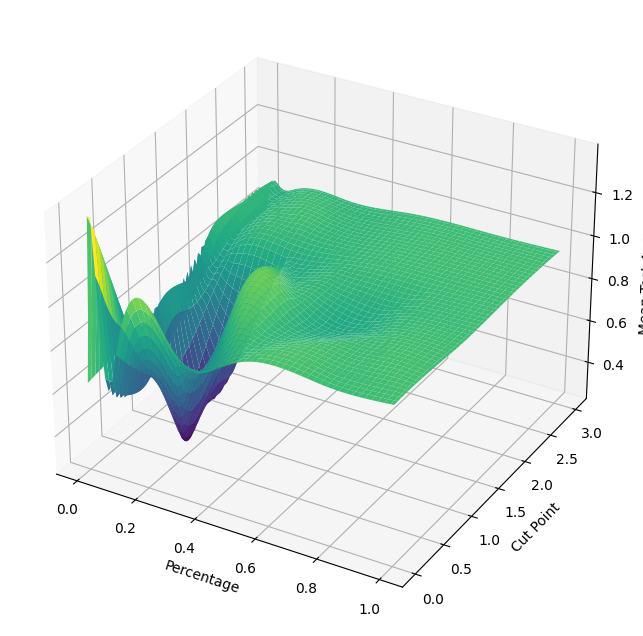

In [11]:
# # Create grid values
# xi = np.linspace(df['Percentage'].min(), df['Percentage'].max(), 100)
# yi = np.linspace(df['Cut Point'].min(), df['Cut Point'].max(), 100)
# xi, yi = np.meshgrid(xi, yi)

# # Interpolate
# zi = griddata((df['Percentage'], df['Cut Point']), df['Mean Test Accuracy'], (xi, yi), method='cubic')

# fig = plt.figure(figsize=(12, 8))
# ax = fig.add_subplot(111, projection='3d')
# ax.plot_surface(xi, yi, zi, cmap='viridis')
# ax.set_xlabel('Percentage')
# ax.set_ylabel('Cut Point')
# ax.set_zlabel('Mean Test Accuracy')
# plt.show()

### Compare to Baseline End-to-end Models
Skip this one for now

In [12]:
# params["lr"] = 0.001
# dataloader_wrapped.update_phase('finetune')

# baseline_results = []

# for sampled_percentage in percentages:

#     if sampled_percentage < 0.01:
#         repeats = 10
#     elif 0.01 <= sampled_percentage < 0.5:
#         repeats = 5
#     else:
#         repeats = 3
    
#     # Create CNN model
#     baseline_model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
#                         hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=params['use_pooling'])
#     baseline_model.to(device)

#     # Reduce the dataset
#     train_loader_reduced = reduce_dataset(dataloader_wrapped.train_loader, sampled_percentage, seed=random.randint(0, 100))
#     val_loader_reduced = reduce_dataset(dataloader_wrapped.val_loader, sampled_percentage, seed=random.randint(0, 100))
#     test_loader_reduced = reduce_dataset(dataloader_wrapped.test_loader, sampled_percentage, seed=random.randint(0, 100))

#     dataset_namespace_new = SimpleNamespace(
#         train_loader=train_loader_reduced, 
#         val_loader=val_loader_reduced, 
#         test_loader=test_loader_reduced
#     )

#     # Train and evaluate
#     trainer = Trainer(baseline_model, dataset_namespace_new, params)
#     train_acc, test_acc, effective_epochs, checkpoints = trainer.train(verbose=0)
#     print(f"Training Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

#     # Store the results
#     baseline_results.append((sampled_percentage, repeat, train_acc, test_acc))

# print(baseline_results)

# # first of all convert results to df and calculate the mean and std of repats
# repeats_mean = []
# i = 0
# for sampled_percentage in percentages:
#     train, test = [], []
#     for repeat in range(repeats):
#         train.append(results[i][3])
#         test.append(results[i][4])
#         i += 1
#     repeats_mean.append((sampled_percentage, np.mean(train), np.std(train), np.mean(test), np.std(test)))
# df_baseline = pd.DataFrame(results, columns=['Percentage', 'Mean Train Accuracy', 'Std Train Accuracy', 'Mean Test Accuracy', 'Std Test Accuracy'])
# df_baseline

Training Accuracy: 1.0000, Test Accuracy: 0.8235
Training Accuracy: 1.0000, Test Accuracy: 0.8048
Training Accuracy: 0.9462, Test Accuracy: 0.8227
Early stopping invoked.
Training Accuracy: 0.4692, Test Accuracy: 0.4970
Training Accuracy: 0.9144, Test Accuracy: 0.8936
Training Accuracy: 0.8802, Test Accuracy: 0.8766
Training Accuracy: 0.9224, Test Accuracy: 0.9247
Training Accuracy: 0.9681, Test Accuracy: 0.9634
Training Accuracy: 0.9805, Test Accuracy: 0.9796
Training Accuracy: 0.9722, Test Accuracy: 0.9720
[(0.001, 2, 1.0, 0.8234931084139065), (0.002, 2, 1.0, 0.8047726805184119), (0.005, 2, 0.9461538461538461, 0.8226702324624563), (0.01, 2, 0.46923076923076923, 0.4970170746759926), (0.05, 2, 0.9143939393939394, 0.8936432832750463), (0.1, 2, 0.8801512287334594, 0.8765686072824521), (0.3, 2, 0.9223692501575299, 0.9247068504422958), (0.5, 2, 0.9681027966742253, 0.9633820201604608), (0.8, 2, 0.9804912612187057, 0.9796338202016046), (1, 2, 0.972232890390967, 0.9720222176506892)]


,Percentage,Mean Train Accuracy,Std Train Accuracy,Mean Test Accuracy,Std Test Accuracy
0,0.001,0,0,0.920000,0.658918
1,0.001,0,1,1.000000,0.490023
2,0.001,0,2,1.000000,0.744908
3,0.001,1,0,0.920000,0.703970
4,0.001,1,1,0.960000,0.647192
...,...,...,...,...,...
145,0.800,-1,1,0.966840,0.966879
146,0.800,-1,2,0.967832,0.961531
147,1.000,-1,0,0.983178,0.982514
148,1.000,-1,1,0.981873,0.980868
